Visualizing sample images from training set:


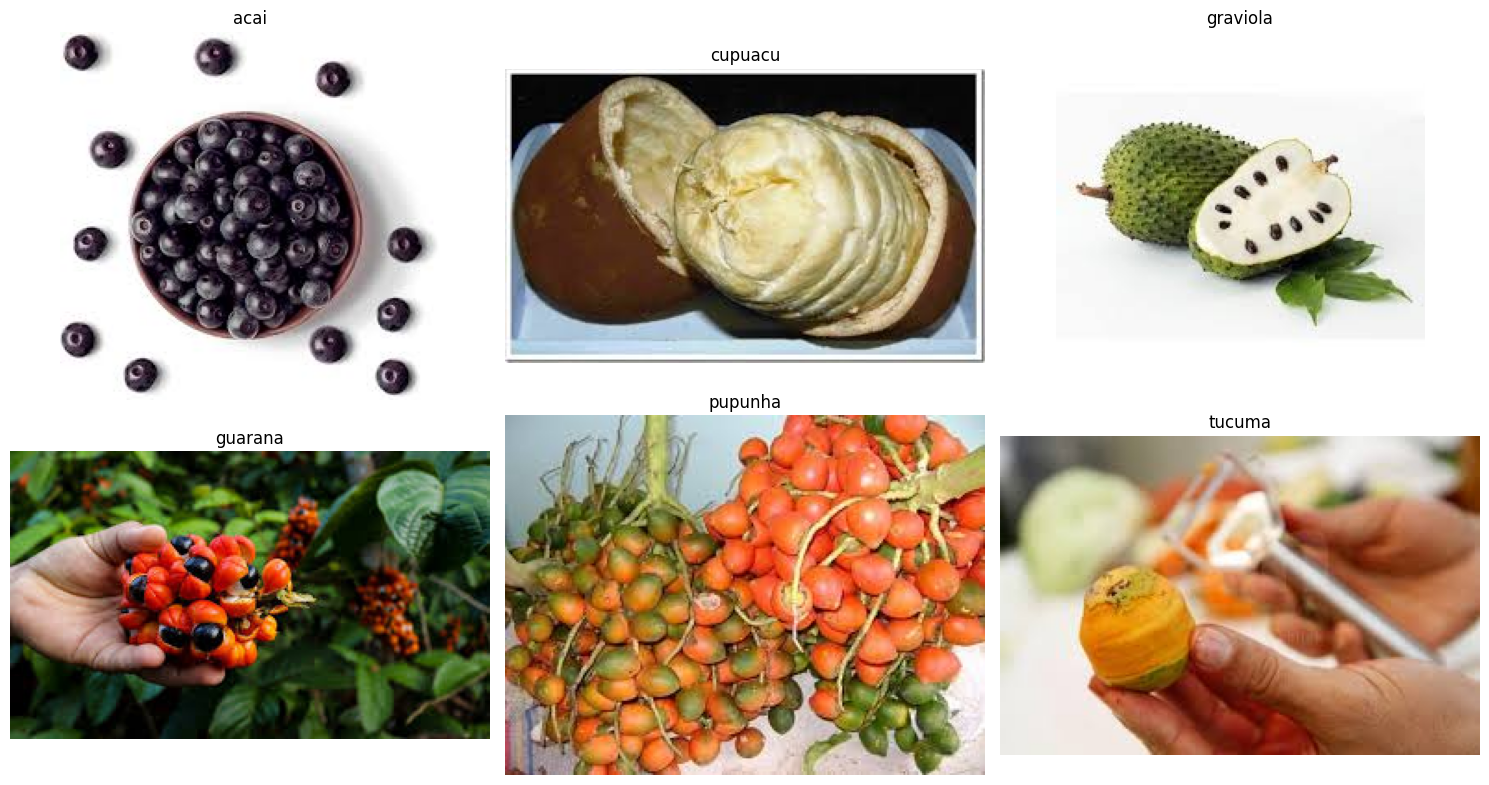


Checking for corrupted images in training set:
No corrupted images found.

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS = 250

BASE_DIR = "/content/drive/MyDrive/AI and Machine Learning/Worksheet5/FruitinAmazon"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

def visualize_sample_images(directory):
    """Display one random image from each class"""
    class_names = sorted(os.listdir(directory))
    plt.figure(figsize=(15, 8))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)

        img = Image.open(image_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def check_corrupted_images(directory):
    """Check and remove corrupted images"""
    corrupted_images = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                    img.close()
                except (IOError, SyntaxError) as e:
                    print(f"Removed corrupted image: {file_path}")
                    corrupted_images.append(file_path)
                    os.remove(file_path)

    if not corrupted_images:
        print("No corrupted images found.")

    return corrupted_images

print("Visualizing sample images from training set:")
visualize_sample_images(TRAIN_DIR)
print("\nChecking for corrupted images in training set:")
check_corrupted_images(TRAIN_DIR)


class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)
print(f"\nFound {num_classes} classes: {class_names}")


In [13]:
def create_dataset(directory, subset=None, shuffle=False):
    """Create a TensorFlow dataset from directory"""
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        validation_split=VALIDATION_SPLIT if subset else None,
        subset=subset,
        seed=123
    )

    # Normalize pixel values to [0, 1]
    rescale = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (rescale(x), y))

    return dataset


train_ds = create_dataset(TRAIN_DIR, subset='training', shuffle=True)
val_ds = create_dataset(TRAIN_DIR, subset='validation', shuffle=False)
test_ds = create_dataset(TEST_DIR)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


In [4]:
# Task 3: Implement the CNN Model
def create_cnn_model():
    """Create CNN model with specified architecture"""
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Classifier
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_cnn_model()
print("\nModel summary:")
model.summary()


Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

print("\nTraining model...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list
)




Training model...
Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.1296 - loss: 2.0237
Epoch 1: val_accuracy improved from -inf to 0.72222, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - accuracy: 0.1319 - loss: 2.0468 - val_accuracy: 0.7222 - val_loss: 1.3941
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.1800 - loss: 1.8246
Epoch 2: val_accuracy did not improve from 0.72222
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.1801 - loss: 1.8259 - val_accuracy: 0.7222 - val_loss: 1.5601
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.2402 - loss: 1.7403
Epoch 3: val_accuracy did not improve from 0.72222
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.2391 - loss: 1.7396 - val_accuracy: 0.2778 - val_loss: 1.7012
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3900 - loss: 1.7009
Epoch 4: val_accuracy did not improve from 0.72222
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.3898 - loss: 1.6973 - val_accuracy: 0.0556 - val_loss: 1.7733
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3941 - loss: 1.6152
Epoch 5: val_accuracy did not improve from 0.72

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.7548 - loss: 0.7778 - val_accuracy: 0.8333 - val_loss: 0.8421
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8796 - loss: 0.5911
Epoch 10: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.8819 - loss: 0.5903 - val_accuracy: 0.3333 - val_loss: 1.2986
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8050 - loss: 0.5557
Epoch 11: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8051 - loss: 0.5477 - val_accuracy: 0.8333 - val_loss: 0.6335
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9502 - loss: 0.3095
Epoch 12: val_accuracy improved from 0.83333 to 0.88889, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.9488 - loss: 0.3083 - val_accuracy: 0.8889 - val_loss: 0.5274
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9595 - loss: 0.2312
Epoch 13: val_accuracy did not improve from 0.88889
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 722ms/step - accuracy: 0.9627 - loss: 0.2265 - val_accuracy: 0.7222 - val_loss: 0.8415
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9699 - loss: 0.1703
Epoch 14: val_accuracy did not improve from 0.88889
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 0.9705 - loss: 0.1681 - val_accuracy: 0.8333 - val_loss: 0.4979
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 1.0000 - loss: 0.1194
Epoch 15: val_accuracy did not improve from 0.88889
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 1.0000 - loss: 0.1172 - val_accuracy: 0.8333 - val_loss: 0.6589
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9902 - loss: 0.0902
Epoch 16: val_accuracy did not improve f

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 779ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9444 - val_loss: 0.3479
Epoch 33/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 33: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9444 - val_loss: 0.3859
Epoch 34/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 34: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8889 - val_loss: 0.3993
Epoch 35/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 35: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8333 - val_loss: 0.4220
Epoch 36/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 1.0000 - loss: 9.5119e-04
Epoch 36: val_accuracy did not impro


Training history plots:


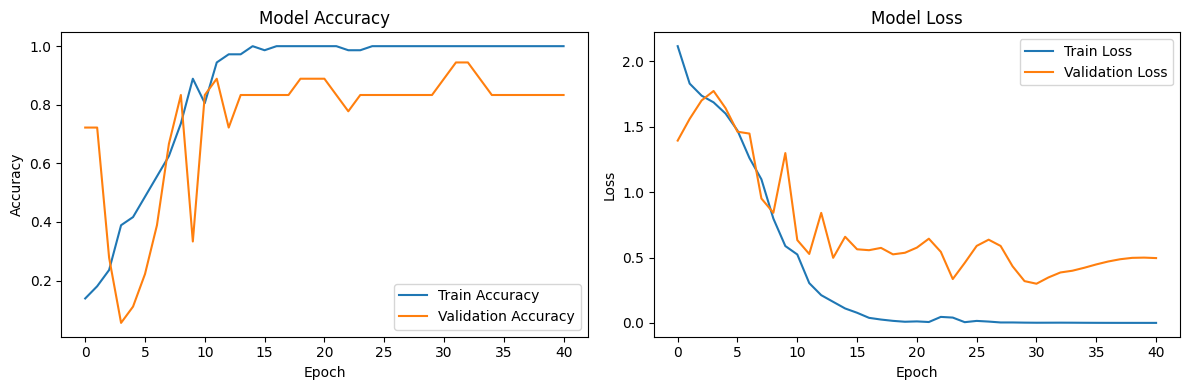

In [7]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nTraining history plots:")
plot_history(history)





In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - accuracy: 0.7000 - loss: 0.9541
Test accuracy: 0.7000


In [12]:
def evaluate_model(dataset, model):
    """Generate predictions and classification report"""
    y_true = []
    y_pred = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))

    present_classes = np.unique(y_true)

    filtered_class_names = [class_names[i] for i in present_classes]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=filtered_class_names,
                              labels=present_classes))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model(val_ds, model)

evaluate_model(test_ds, model)

model.save('fruit_classifier.h5')


Classification Report:
              precision    recall  f1-score   support

     pupunha       1.00      0.67      0.80         3
      tucuma       0.93      0.93      0.93        15

   micro avg       0.94      0.89      0.91        18
   macro avg       0.97      0.80      0.87        18
weighted avg       0.94      0.89      0.91        18


Confusion Matrix:
[[ 0  0  0]
 [ 0  2  1]
 [ 1  0 14]]



Classification Report:
              precision    recall  f1-score   support

        acai       0.56      1.00      0.71         5
     cupuacu       0.80      0.80      0.80         5
    graviola       1.00      0.60      0.75         5
     guarana       0.50      0.60      0.55         5
     pupunha       0.80      0.80      0.80         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.70        30
   macro avg       0.78      0.70      0.70        30
weighted avg       0.78      0.70      0.70        30


Confusion Matrix:
[[5 0 0 0 0 0]
 [0 4 0 1 0 0]
 [1 0 3 1 0 0]
 [1 0 0 3 1 0]
 [0 0 0 1 4 0]
 [2 1 0 0 0 2]]
